Modules.

In [21]:
import numpy as np
from numpy import radians as rad
from numpy import degrees as deg
from numpy import sin, cos, tan, arcsin, arccos, arctan, arctan2, mean

import pandas as pd
from dataclasses import dataclass
import itertools

import warnings
from scipy.optimize import curve_fit, OptimizeWarning

warnings.simplefilter("error", OptimizeWarning)

from typing import Callable, Tuple
from collections.abc import Iterable

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

Numerical constants.

In [2]:
SHEAR_MODULUS = 2.4e10  # Pa
ROCK_DENSITY = 2700  # kg / m^3
MAGMA_DENSITY = 2700  # kg / m^3
MARS_GRAVITY = 3.72  # m / s^2
MARS_EQ_RADIUS = 3_396_200  # m

AZ1_UNCERTAINTY = 7  # degrees

# for plotting numerical
PLOT_WIDTH = 200_000

# scale length dimensions to prevent overflow
LENGTH_SCALE_MULT = 1_000_000

# for cutoff envelope and first guess in non-linear regression
MAX_EPV = 7e22  # J
TEST_D = 20_000  # m
MAX_ITERATIONS = 80

# parameter conversion factor
EPV_OVER_K = 16 * np.pi * SHEAR_MODULUS / 9

## Functions

In [3]:
def save_pdf(name: str = 'plot'):
    plt.tight_layout()  # prevent clipping edge labels
    plt.savefig(f'figures/{name}.pdf')


def mogi_tilt(dist, epv, d):
    k = epv / EPV_OVER_K

    # scale to prevent overflow
    r1_scale = dist / LENGTH_SCALE_MULT
    k_scale = k / (LENGTH_SCALE_MULT ** 3)
    d_scale = d / LENGTH_SCALE_MULT

    num = 3 * k_scale * d_scale * r1_scale
    denom = (d_scale**2 + r1_scale**2)**2.5 + \
        k_scale * (d_scale**2 - 2*r1_scale**2)
    return np.degrees(np.arctan2(num, denom))


def calculate_epv(depth, radius, aspect, pmult):
    half_height = radius * aspect
    volume = (4/3) * np.pi * radius**2 * half_height
    pressure = ROCK_DENSITY * MARS_GRAVITY * depth * pmult
    return volume * pressure


def dist(lat_sample, lon_sample, lat_center, lon_center):
    '''distance between pts 1 and 2'''
    lat1 = rad(lat_sample)
    lon1 = rad(lon_sample)
    lat2 = rad(lat_center)
    lon2 = rad(lon_center)
    rads = arccos(
        cos(lat1) * cos(lat2)
        * cos(lon2 - lon1)
        + sin(lat1) * sin(lat2)
    )
    return rads * MARS_EQ_RADIUS


def bearing(lat_sample, lon_sample, lat_center, lon_center):
    '''angle from pt 1 AWAY from pt 2'''
    lat1 = rad(lat_sample)
    lon1 = rad(lon_sample)
    lat2 = rad(lat_center)
    lon2 = rad(lon_center)
    y = sin(lon2 - lon1) * cos(lat2)
    x = cos(lat1) * sin(lat2) \
        - sin(lat1) * cos(lat2) * cos(lon2 - lon1)
    return (180 + deg(arctan2(y, x))) % 360


# for beta, discordance calculations
def signed_ang_diff(az, bearing):
    return ((az - bearing + 180) % 360) - 180


def sl1(beta1, beta2, sl2):
    beta1 = rad(beta1)
    beta2 = rad(beta2)
    sl2 = rad(sl2)
    arg = sin(beta2) * sin(sl2) / sin(beta1)
    if arg < 0 or arg > 1:  # not possible
        return np.nan
    else:
        sl1 = arcsin(arg)
        return deg(sl1)


def proj(beta, sl):
    '''project small circle point onto great circle'''
    beta = rad(beta)
    sl = rad(sl)
    proj = arctan(tan(beta) * cos(beta))
    return deg(proj)


def tilt(beta1_measured, beta2, sl2, dist, az1_uncertainty=AZ1_UNCERTAINTY):

    # within uncertainty (non-discordance condition)
    if np.abs(signed_ang_diff(beta1_measured, beta2)) < az1_uncertainty:
        return 0 # early exit from function

    # beta1 uncertainty boundaries 
    beta1_possible = np.array([
        beta1_measured + az1_uncertainty,
        beta1_measured - az1_uncertainty
    ])

    # compute resulting sl1 for each beta1 boundary
    sl1_possible = np.array([
        sl1(beta1, beta2, sl2) for beta1 in beta1_possible
    ])

    # remove any impossible boundary calculations
    beta1_possible = beta1_possible[~np.isnan(sl1_possible)]
    sl1_possible = sl1_possible[~np.isnan(sl1_possible)]

    # make (beta1, sl1) pairs of resulting (mathematically possible)
    beta1_sl1_zip = zip(beta1_possible, sl1_possible)

    # no possible tilts (mathematical condition)
    if len(sl1_possible) == 0:
        return np.nan # early exit from function

    # evaluate tilt for 
    tilt_possible = np.array(
        [proj(beta2, sl2) - proj(*pair)for pair in beta1_sl1_zip]
    )

    # find index (boundary) with the lowest tilt magnitude 
    lowest_abs_tilt_arg = np.argmin(np.abs(tilt_possible))

    # envelope cutoff (physical plausibility condition)
    max_tilt = mogi_tilt(dist=dist, epv=MAX_EPV, d=TEST_D)
    min_tilt = mogi_tilt(dist=dist, epv=-MAX_EPV, d=TEST_D)

    if tilt_possible[lowest_abs_tilt_arg] > max_tilt:
        return np.nan # early exit
    if tilt_possible[lowest_abs_tilt_arg] < min_tilt:
        return np.nan # early exit

    # if no early exits, return lowest computed tilt 
    return tilt_possible[lowest_abs_tilt_arg]

Envelope plot.

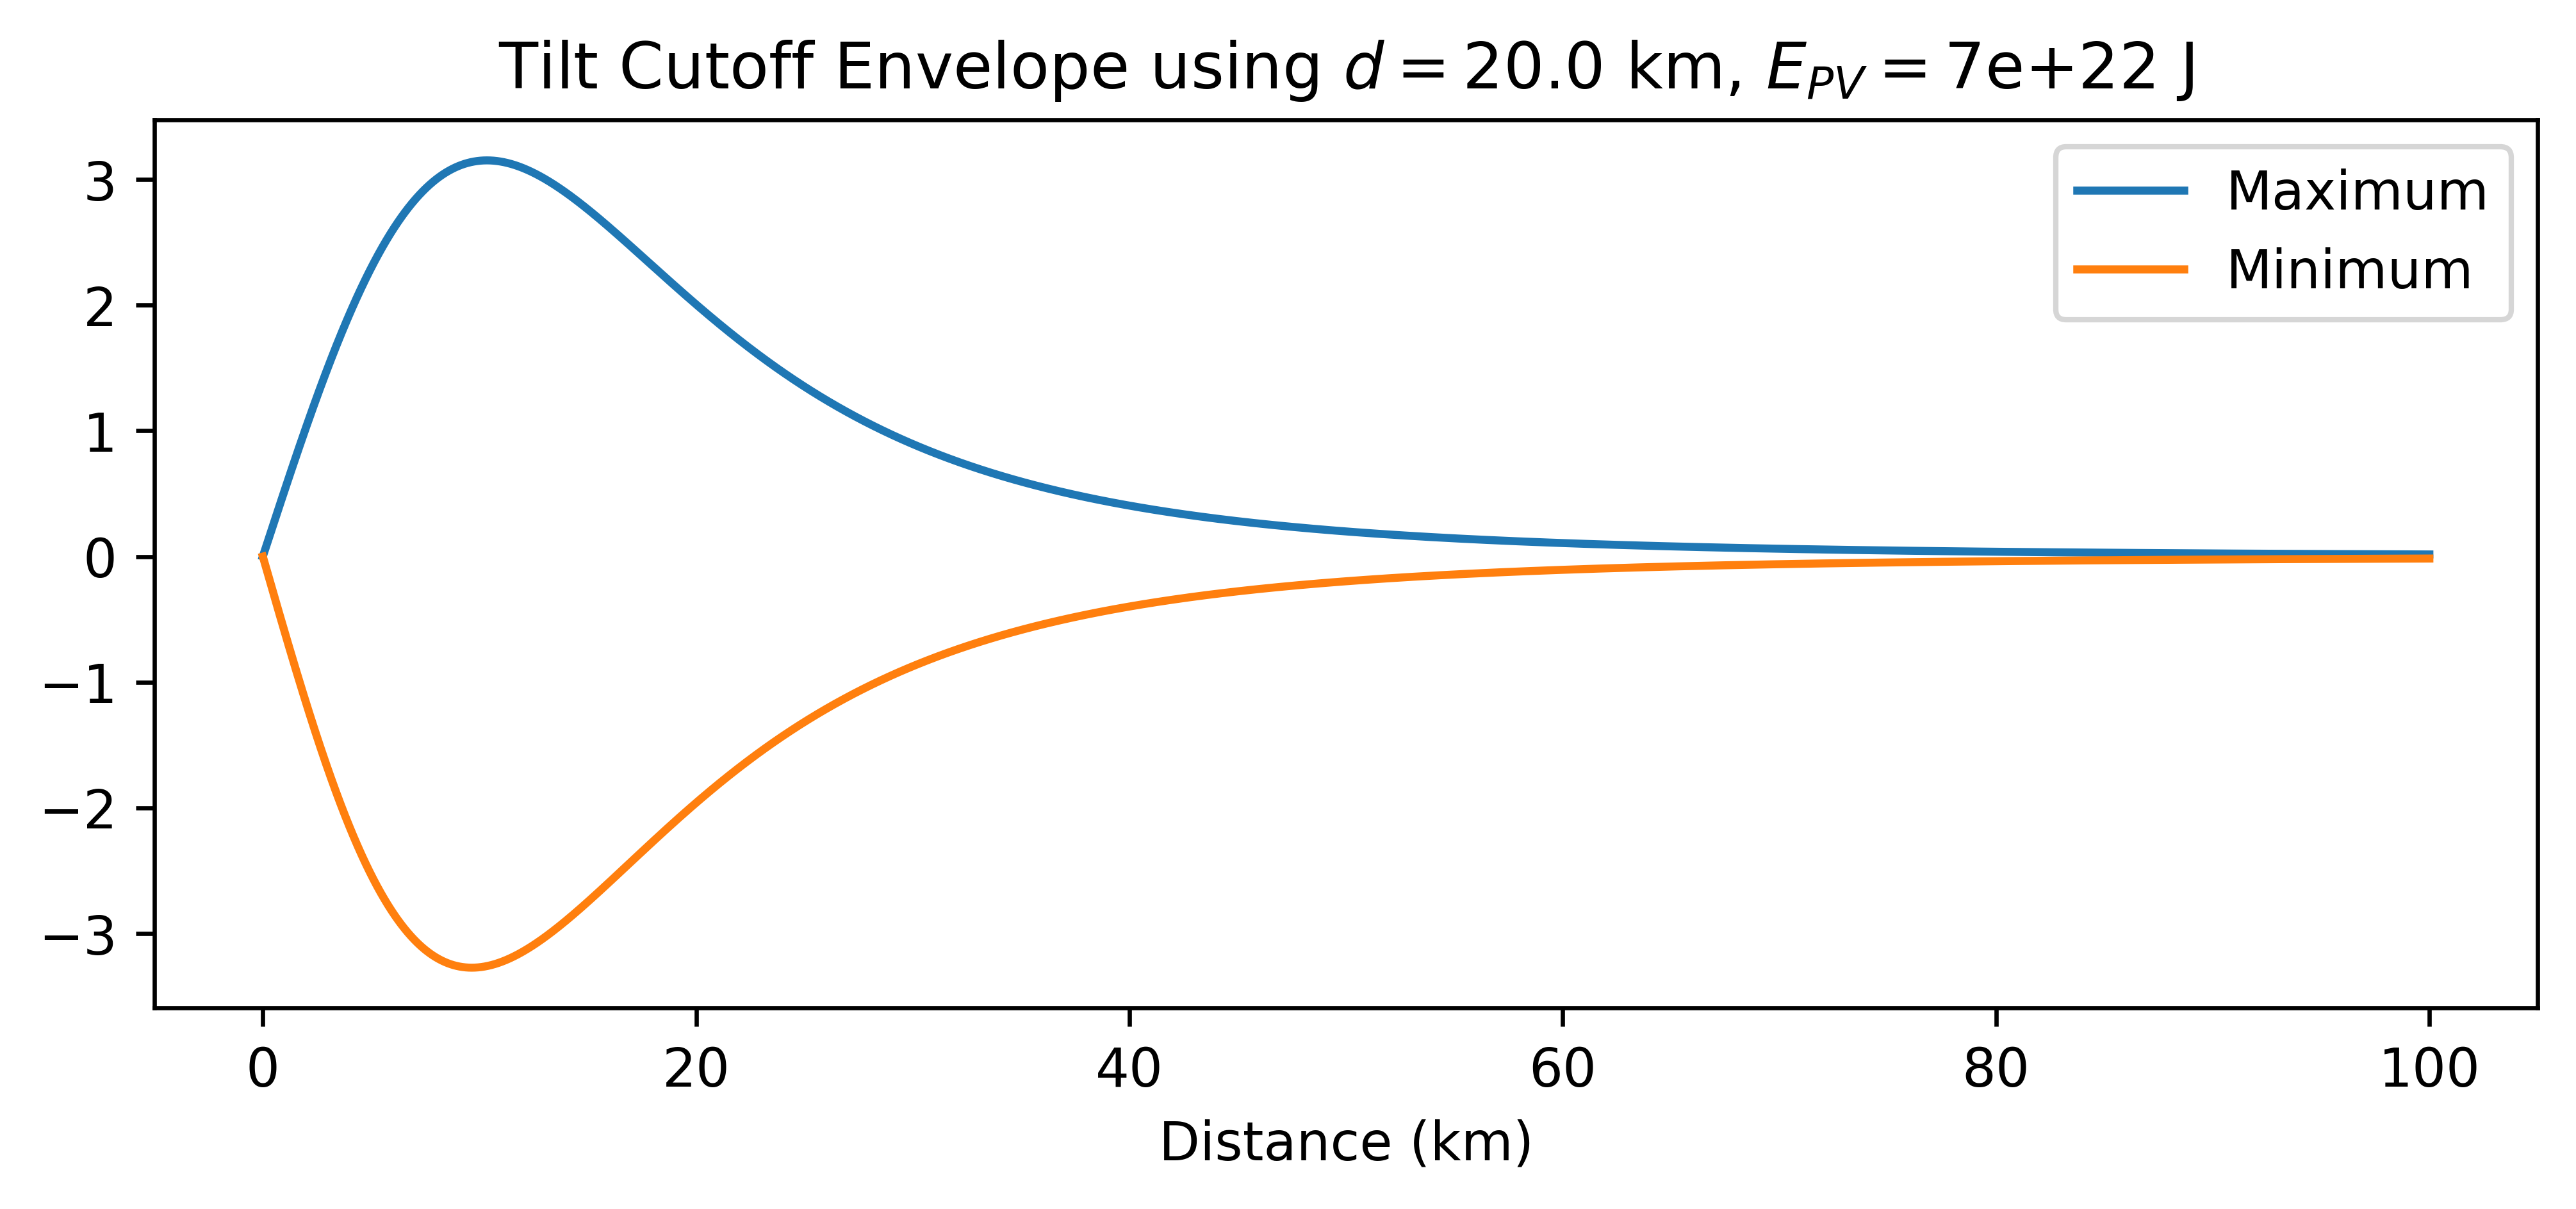

In [4]:
fig = plt.figure(figsize = (8, 3), dpi=600)

test_dist = np.arange(1, 100_000)
test_max_tilt = mogi_tilt(test_dist, MAX_EPV, TEST_D)
test_min_tilt = mogi_tilt(test_dist, -MAX_EPV, TEST_D)
test_dist_km = test_dist / 1000

sns.lineplot(x=test_dist_km,y=test_max_tilt,label='Maximum')
sns.lineplot(x=test_dist_km,y=test_min_tilt,label='Minimum')
plt.title(f'Tilt Cutoff Envelope using $d = ${TEST_D/1000} km, ' + "$E_{PV} = $" + f'{MAX_EPV} J')
plt.xlabel('Tilt (deg)')
plt.xlabel('Distance (km)')

def add_envelope_to_plot(min: bool = True, max: bool = True):
    if max:
        sns.lineplot(x=test_dist_km,y=test_max_tilt, c='black', linestyle='--')
    if min:
        sns.lineplot(x=test_dist_km,y=test_min_tilt, c='black', linestyle='--')

# save_pdf(name='envelope')

## Map Data

Read samples.csv and centers.csv and extract IDs for each.

In [5]:
# location to read .csv files
map_path = "../GEOL192-GIS/data/"


centers = pd.read_csv(f'{map_path}centers.csv').set_index('cID')
samples = pd.read_csv(f'{map_path}samples.csv').set_index(['sID', 'FEATURE'])

cIDs = tuple(centers.index)
sIDs = tuple(index[0] for index in samples.index)

Define an object to organize, calculate, and plot map data for a single center point.

In [6]:
@dataclass
class Center:
    cID: int

    def __post_init__(self):
        self.data = samples.copy()

        # this of course only works for unique self.cIDs
        self.lat = centers.loc[self.cID, 'LAT']
        self.lon = centers.loc[self.cID, 'LON']
        self.calculate()

    def plot(self, name: str = None):  # type: ignore
        fig = plt.figure(figsize=(8, 5), dpi=600)

        sns.scatterplot(data=self.data, x='dist', y='tilt')

        plt.title(f"Tilt from Center {self.cID} under cutoff: {MAX_EPV = }, {TEST_D = }")
        plt.xlabel("Distance (km)")
        plt.ylabel("Tilt (deg)")

        # save plot with name if passed as argument
        if name is not None:
            save_pdf(name)

    def calculate(self):

        self.data['dist'] = self.data.apply(
            lambda row: dist(
                lat_sample=row['LAT'], lon_sample=row['LON'],
                lat_center=self.lat, lon_center=self.lon
            ),
            axis=1
        )

        self.data['dist_km'] = self.data.apply(
            lambda row: row['dist'] / 1000,
            axis=1
        )

        self.data['bearing'] = self.data.apply(
            lambda row: bearing(
                lat_sample=row['LAT'], lon_sample=row['LON'],
                lat_center=self.lat, lon_center=self.lon
            ),
            axis=1
        )

        self.data['beta1'] = self.data.apply(
            lambda row: signed_ang_diff(
                az=row['AZ1'], bearing=row['bearing']
            ),
            axis=1
        )

        self.data['beta2'] = self.data.apply(
            lambda row: signed_ang_diff(
                az=row['AZ2'], bearing=row['bearing']
            ),
            axis=1
        )
        
        self.data['tilt'] = self.data.apply(
            lambda row: tilt(
                beta1_measured=row['beta1'],
                beta2=row['beta2'], sl2=row['SL2'],
                dist=row['dist']
            ),
            axis=1
        )

Make an object for each center. This takes less than a minute on my machine.

In [7]:
centers_calc = [Center(cID) for cID in cIDs]

Define sample populations based on their sIDs and feature type.

In [8]:
@dataclass
class Population:
    feature: tuple = ('flow', 'channel')
    name: str = ''
    sIDs: tuple = sIDs  # type: ignore

# not used
SE_ALL_sIDs = (
    41, 193, 194, 195, 196, 197, 198, 202, 203, 430, 431, 432, 438, 439, 440, 441, 442, 443, 444, 445, 477, 478, 479, 480, 481, 490,
    491, 492, 493, 524, 525, 526, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549
)

POP_A_sIDs = (
    198, 438, 439, 440, 441, 442, 443, 444, 445, 490, 491, 492, 493
)

POP_B_sIDs = (
    193, 194, 195, 196, 197, 477, 478, 479, 480, 481, 544, 545, 548, 549
)

POP_C_sIDs = (
    529, 530, 531, 532, 533, 537, 538, 539, 540, 541, 542, 543
)

pop_all = Population(name='all')
pop_flow = Population(('flow',),name='flow')
pop_channel = Population(('channel',),name='channel')

pop_a = Population(name='A', sIDs=POP_A_sIDs)
pop_b = Population(name='B', sIDs=POP_B_sIDs)
pop_c = Population(name='C', sIDs=POP_C_sIDs)

Define functions for center evaluation. These return dicts with score names as keys. They need to return dicts of the same length with NaN values if any error occurs, rather than skipping or any other behavior.

In [32]:
def summit_score(df: pd.DataFrame) -> dict:
    try:
        score = {'summit_score': mean(np.abs(df['beta1']))}
    except:
        score = {'summit_score': np.nan}
    return score


def fit_mogi_function(df: pd.DataFrame):

    # initial guess lower than envelope
    if np.mean(df['tilt']) < 0:
        p0 = -MAX_EPV / 1000, TEST_D
    else:
        p0 = MAX_EPV / 1000, TEST_D

    params, pcov = curve_fit(
        f=mogi_tilt,
        xdata=df['dist'],
        ydata=df['tilt'],
        p0=p0,
        maxfev=MAX_ITERATIONS,
        method='lm'
    )
    return params, pcov


def inflation_score(df: pd.DataFrame) -> dict:

    # get size of population before taking tiltable subset
    pop_size = len(df)
    df = df.loc[df['tilt'].notnull()]

    # initialize output
    scores = {
        'frac_tiltable': len(df) / pop_size,  # doesn't depend on fit results
        'Epv_est': np.nan,
        'log10_Epv_est': np.nan,
        'Epv_is_positive': np.nan,
        'Epv_err': np.nan,
        'd_est': np.nan,
        'd_err': np.nan,
    }

    # attempt regression
    try:
        params, pcov = fit_mogi_function(df)

        # unpack param estimate and variance
        epv, d = params
        epv_var, d_var = np.sqrt(np.diag(pcov))

        if np.isnan(epv_var):
            raise ValueError('Failed to estimate energy variance')

        if np.isnan(d_var):
            raise ValueError('Failed to estimate depth variance')

        # rewrite scores in dict
        scores['Epv_est'] = epv
        scores['log10_Epv_est'] = np.log10(np.abs(epv))
        scores['Epv_is_positive'] = epv > 0
        scores['Epv_err'] = abs(epv_var / epv)
        scores['d_est'] = d
        scores['d_err'] = abs(d_var / d)

    # catch regression failure
    except OptimizeWarning:  # does not converge
        pass

    except RuntimeError:
        pass

    except ValueError:
        pass

    except TypeError:  # 'func input vector length N=2 must not exceed func output vector length M=1'
        pass

    return scores

A criterion is just a combination of an evaluation function and a population on which to use it.

In [33]:
@dataclass
class Criterion:
    func: Callable
    pop: Population

criteria = [
    Criterion(summit_score, pop_all),
    Criterion(summit_score, pop_flow),
    Criterion(summit_score, pop_channel),
    Criterion(inflation_score, pop_a),
    Criterion(inflation_score, pop_b),
    Criterion(inflation_score, pop_c),
]

Perform each evaluation for each center point. This takes less than two minutes on my machine, the vast majority of which is from the curve_fit function calls.

In [34]:
def evaluate_center(center: Center, crit: Criterion):
    pop_subset = center.data.loc[(crit.pop.sIDs, crit.pop.feature), :]
    return crit.func(pop_subset)


scores = {}
score_names = []

# note: will get score name out of order if any criteria throw errors, so those need to be handled in each evaluation function
for center in centers_calc[:70]:
    centers_eval = []
    for crit in criteria:
        center_crit_scores = evaluate_center(center, crit)
        for key, val in center_crit_scores.items():
            centers_eval.append(val)

            full_score_name = f'{crit.pop.name}_{key}'
            if full_score_name not in score_names:
                score_names.append(full_score_name)
    scores[center.cID] = centers_eval

/Users/henry/opt/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
/Users/henry/opt/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
/Users/henry/opt/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
/Users/henry/opt/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:900: RuntimeWarning: invalid value encountered in multiply
  pcov = pcov * s_sq
/Users/henry/opt/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
/Users/henry/opt/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:900: RuntimeWarning: invalid value encountered in multiply
  pcov = pcov * s_sq
/Users/henry/opt/ana

Write the evaluated scores to disk.

In [36]:
centers_eval = pd.DataFrame(scores).transpose().set_axis(score_names, axis=1)

# replace inf with NaN to ensure export as numbers
centers_eval = centers_eval.replace([np.inf, -np.inf], np.nan)

centers_eval.to_csv(
    f'{map_path}centers_eval_Mar30_first70.csv',
    index_label='cID'
)

Are computed parameters simply "hugging" those used to define the mogi tilt envelope? While they are centered around zero, they spread over multiple orders of magnitude, particularly the energy term which is much less constrained. Depth ranging over even a fraction of an oder of magnitude is convincing here (considering that the true range of realistic reservoir depths is a very narrow range).

In [ ]:
def envelope_hugging(pops: list, name: str = None):  # type: ignore

    fig = plt.figure(figsize=(8, 4), dpi=600)
    ax_epv = fig.add_subplot(1, 2, 1)
    ax_d = fig.add_subplot(1, 2, 2)

    ax_d.yaxis.set_label_position("right")
    ax_d.yaxis.tick_right()

    fig.suptitle(
        f'Parameter Estimates "Hugging" Envelope with '
        + "$E_{PV} = $" + f'{MAX_EPV} J, '
        + f'$d = ${TEST_D/1000} km'
    )

    for pop in pops:

        d_est = centers_eval[f'{pop.name}_d_est'][
            centers_eval[f'{pop.name}_d_est'].notna()
        ]
        epv_est = centers_eval[f'{pop.name}_Epv_est'][
            centers_eval[f'{pop.name}_Epv_est'].notna()
        ]

        n_d = len(d_est)
        n_epv = len(epv_est)

        sns.kdeplot(x=np.log10(np.abs(epv_est / MAX_EPV)),
                    ax=ax_epv, label=f'{pop.name} (n = {n_epv})')

        sns.kdeplot(x=d_est / TEST_D, ax=ax_d, label=f'{pop.name} (n = {n_d})',bw_adjust=3)

    plt.sca(ax_d)
    plt.ylim((None, None))
    ax_d.vlines(x=1, ymin=0, ymax=1, colors=['black'])
    plt.xlabel('$d:$ fit / envelope')
    plt.legend()

    plt.sca(ax_epv)
    plt.ylim((None, None))
    ax_epv.vlines(x=0, ymin=0, ymax=1, colors=['black'])
    plt.xlabel('$E_{PV}:$ log |fit / envelope|')
    plt.legend()

    if name is not None:
        save_pdf(name)

envelope_hugging([pop_a], ) # name='hugging-a'
envelope_hugging([pop_c], ) # name='hugging-c'

Examine scatter plots and mogi fit functions for individual center candidates relative to a population.

In [ ]:
def plot_scatter_fit(cIDs: list, pop: Population, name: str = None, show_max: bool = False, show_min: bool = False, height: int = 3):  # type: ignore

    fig = plt.figure(figsize=(8, height), dpi=600)

    for cID in cIDs:
        spot_check = centers_calc[cID - 1].data.loc[(pop.sIDs, pop.feature), :]
        sns.scatterplot(data=spot_check, x='dist_km', y='tilt')
        eval = centers_eval.loc[cID]

        pv = eval[f'{pop.name}_Epv_est']
        d = eval[f'{pop.name}_d_est']

        frac = round(eval[f'{pop.name}_frac_tiltable'],1)

        if not np.isnan(pv):
            mogi_dist = np.linspace(
                0,
                np.max(spot_check['dist'][spot_check['tilt'].notna()]),
                100
            )
            mogi_dist_km = mogi_dist / 1000
            label = f"cID: {cID}. " + "$\\log|E_{pv}\\ /\\ J|$: " + \
                f"{round(np.log10(np.abs(pv)),1)}, $d$: {round(d)} (f = {frac})"
            sns.lineplot(x=mogi_dist_km, y=mogi_tilt(
                mogi_dist, pv, d), label=label)

    # set extent based on data first, then add envelope
    plt.xlim(0, None)
    plt.ylim(None, None)
    add_envelope_to_plot(max=show_max, min=show_min)

    plt.ylabel('Tilt (deg)')
    plt.xlabel('Distance (km)')
    plt.title(f'Center Candidates for Pop. {pop.name}')
    plt.legend(loc='upper left') #

    # save plot with name if passed as argument
    if name is not None:
        save_pdf(name)

In [ ]:
plot_scatter_fit(
    [41, 81, 102, 103], pop_a, show_min=True, show_max=True, height=5,
) # name='scatter-fit-a'

plot_scatter_fit(
    [197], pop_a, show_min=True, show_max=True,
) # name='scatter-fit-a-outlier'

## Numerical Model Data

Read initial positions and displacement vectors (radial and vertical components) of mesh nodes.

In [86]:
model_path = "../GEOL192-Model/data/"

# paleo-edifice spline data
topo = np.genfromtxt(f'{model_path}z1.csv', delimiter=",").T


def model_pos1_from_csv(name: str):
    r = np.genfromtxt(model_path + "rdisp_" + name, delimiter=",")[:, 0]
    z = np.interp(r, *topo, right=0) # interpolate z1 into topography
    return np.array([r, z]).T


def model_disp_from_csv(name: str):
    r = np.genfromtxt(f'{model_path}rdisp_{name}', delimiter=",")[:, 1]
    z = np.genfromtxt(f'{model_path}zdisp_{name}', delimiter=",")[:, 1]
    return np.array([r, z]).T

Define objects for displaced nodes and surface edges (the latter defined by a consecutive pair of the former). Tilt calculation in the edge class.

In [45]:
@dataclass
class Node:
    pos1: Tuple[float, float]
    disp: Tuple[float, float]

    def __post_init__(self):
        self.pos2 = self.pos1 + self.disp


@dataclass
class Edge:
    proximal: Node  # (A in text)
    distal: Node  # (B in text)

    def __post_init__(self):
        # relative dimensions [r, z] of initial and displaced segments
        self.shape1 = self.distal.pos1 - self.proximal.pos1  # type: ignore
        self.shape2 = self.distal.pos2 - self.proximal.pos2  # type: ignore

        # mean position of initial and displaced segments
        self.pos1 = (self.distal.pos1 + self.proximal.pos1) / 2  # type: ignore
        self.pos2 = (self.distal.pos2 + self.proximal.pos2) / 2  # type: ignore

        # radial distances for plotting
        self.dist = self.pos2[0]
        self.dist_km = self.dist / 1000

        # initial and displaced slopes (positive downward from center)
        # index [1] is z component; [0] is r component
        self.slope1 = deg(arctan2(-self.shape1[1], self.shape1[0]))
        self.slope2 = deg(arctan2(-self.shape2[1], self.shape2[0]))

        self.tilt = self.slope2 - self.slope1

Define model class with parameter combination (geometry, overpressure). It reads .csv files, builds nodes & edges, etc.

In [46]:
@dataclass
class Model:
    params: dict

    def __post_init__(self):

        self.radius = self.params['radius']
        self.half_height = self.radius * self.params['aspect']

        self.dP = self.params['pmult'] * \
            self.params['depth'] * ROCK_DENSITY * MARS_GRAVITY

        self.res_vol = (4 / 3) * np.pi * self.radius**2 * self.half_height

        self.epv = self.dP * self.res_vol
        self.d = self.params['depth'] + self.half_height

        filename = f"depth_{self.params['depth']}_radius_{self.params['radius']}_aspect_{self.params['aspect']}_pmult_{self.params['pmult']}_grav_{int(self.params['grav'])}_topo_{int(self.params['topo'])}.csv"

        # read initial positions and displacements
        self.pos1 = model_pos1_from_csv(filename)
        self.disp = model_disp_from_csv(filename)

        # subtract out gravitational component (with no overpressure)
        if self.params['grav']:
            filename_p0 = filename.replace(
                f"pmult_{self.params['pmult']}", "pmult_0")
            self.disp -= model_disp_from_csv(filename_p0)

        # make z1 flat for flat model
        if not self.params['topo']:
            self.pos1[1] = np.zeros(len(self.pos1[1]))

        # build nodes from pos1 and disp if pos1 within defined length
        self.num_nodes = next(i for i, val in enumerate(self.pos1)
                              if val[0] > PLOT_WIDTH)

        self.nodes = [Node(self.pos1[i], self.disp[i])
                      for i in range(self.num_nodes)]

        # build edges from consecutive node pairs
        self.node_pairs = zip(self.nodes[:-1], self.nodes[1:])
        self.edges = [Edge(*pair) for pair in self.node_pairs]

        # put edge attributes into dict of lists
        self.data = pd.DataFrame(
            [vars(edge) for edge in self.edges])

        self.attributes = self.data.to_dict("list")

Define parametric sweep class to mirror COMSOL iterative modelling. It includes a flexible plot function which distinguishes between constant and variable parameters within the sweep and can handle comparisons with the analytical Mogi solution.

In [138]:
geom_keys = ['depth', 'radius', 'aspect']

# parameter sweep in SI units (to match csv output from COMSOL)
@dataclass
class ParamSweep:
    params: dict

    def __post_init__(self):

        # define constant parameters for labelling once in title
        self.constants = {key: val[0]
                          for key, val in self.params.items() if len(val) == 1}

        # define variable parameters for labelling individually
        self.variables = [key for key, val in self.params.items() if len(val) > 1]

        self.models = [Model(dict(zip(self.params, item)))
                       for item in itertools.product(*self.params.values())]

    def plot_tilt(self, calc_mogi: bool = False, fit_mogi: bool = False, name: str = None):  # type: ignore

        fig = plt.figure(figsize=(8, 3), dpi=600)

        title = f'{self.constants}'.replace(
            "{", "").replace("}", "").replace("'", "")
        
        for model in self.models:

            model_epv = calculate_epv(
                model.params['depth'],
                model.params['radius'],
                model.params['aspect'],
                model.params['pmult']
            )

            # define variables specific to each config
            if len(self.variables) > 0:
                label = ': {}'.format(
                    {param: model.params[param] for param in self.variables})
                label = label.replace("{", "")
                label = label.replace("}", "")
                label = label.replace("'", "")
            else:
                label = ""

            # plot numerical output
            sns.lineplot(data=model.attributes,
                             y="tilt", x="dist_km", label=f'Numerical{label}')

            if calc_mogi:
                dist = np.array(model.attributes['dist'])
                dist_km = dist / 1000
                tilt = mogi_tilt(
                    dist=dist,
                    epv=model_epv,
                    d=model.params['depth']
                )
                sns.lineplot(x=dist_km, y=tilt, label=f'Mogi (calc){label}')

            if fit_mogi:
                params, _ = fit_mogi_function(df=model.data)
                epv, d = params

                sns.lineplot(x=model.data['dist_km'], y=mogi_tilt(
                    model.data['dist'], epv, d), label=f'Mogi (fit){label}')
                
                epv_overestimate = epv / model_epv
                d_overestimate = d / model.params['depth']

                title += '\n Fitted parameter overestimation Factors: '
                title += '$E_{PV}:$' + f'{round(epv_overestimate,2)}, '
                title += '$d:$' + f'{round(d_overestimate, 2)}'


        plt.title(f"{title}")
        plt.xlabel("Distance (km)")
        # plt.xlim(8, 16) 
        # plt.ylim(.34, .37)
        plt.ylabel("Tilt (deg)")
        plt.legend(loc="upper right")

        # save plot with name if passed as argument
        if name is not None:
            save_pdf(name)
    
    def plot_section(self, name: str = None): # type: ignore
        # subset of params
        geom_params = {k:self.params[k] for k in geom_keys if k in self.params}

        # define constant parameters for labelling once in title
        constants = {key: val[0]
                          for key, val in geom_params.items() if len(val) == 1}

        # define variable parameters for labelling individually
        variables = [key for key, val in geom_params.items() if len(val) > 1]
        
        fig = plt.figure(figsize=(8, 3), dpi=600)

        title = f'{constants}'.replace(
            "{", "").replace("}", "").replace("'", "")

        depth = self.params['depth']
        radius = self.params['radius']
        aspect = self.params['aspect']

        top_surface_km = np.concatenate((topo, [[2_000_000], [0]]),1) / 1000

        fig, ax = plt.subplots(figsize=(8,3),dpi=600)

        sns.lineplot(x=top_surface_km[0], y=top_surface_km[1], c='black')

        sns.lineplot(x=[0, 2000], y=[-600, -600], c='black')

        plt.vlines(x=[0,2_000], ymin=-600, ymax=[top_surface_km[1,0], 0], colors=['black'])

        for geometry in itertools.product(depth, radius, aspect):
            depth, radius, aspect = geometry
            v= -depth/1000    #y-position of the center
            a= radius / 1000     #radius on the x-axis
            b= radius*aspect / 1000    #radius on the y-axis
            t = np.linspace(-np.pi/2, np.pi/2, 100)
            plt.plot(a*np.cos(t), v+b*np.sin(t))

        plt.xlim(-1, 100)
        plt.ylim(-31, 30)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        # save plot with name if passed as argument
        if name is not None:
            save_pdf(name)

Define specific parametric sweeps.

In [139]:
grav_topo_test_sweep = ParamSweep({
    "depth": [15_000],
    "radius": [20_000],
    "aspect": [.4],
    "pmult": [.6],
    "grav": [True, False],
    "topo": [True, False],
})

mogi_shallow_oblate_test_sweep = ParamSweep({
    "depth": [15_000],
    "radius": [20_000],
    "aspect": [.4],
    "pmult": [.6],
    "grav": [False],
    "topo": [True],
})

mogi_test_sweep = ParamSweep({
    "depth": [25_000],
    "radius": [5_000],
    "aspect": [1],
    "pmult": [1],
    "grav": [False],
    "topo": [False],
})

full_sweep = ParamSweep({
    "depth": [25_000], # 25
    "radius": [5_000], # 5
    "aspect": [1],
    "pmult": [1],
    "grav": [False],
    "topo": [False],
})

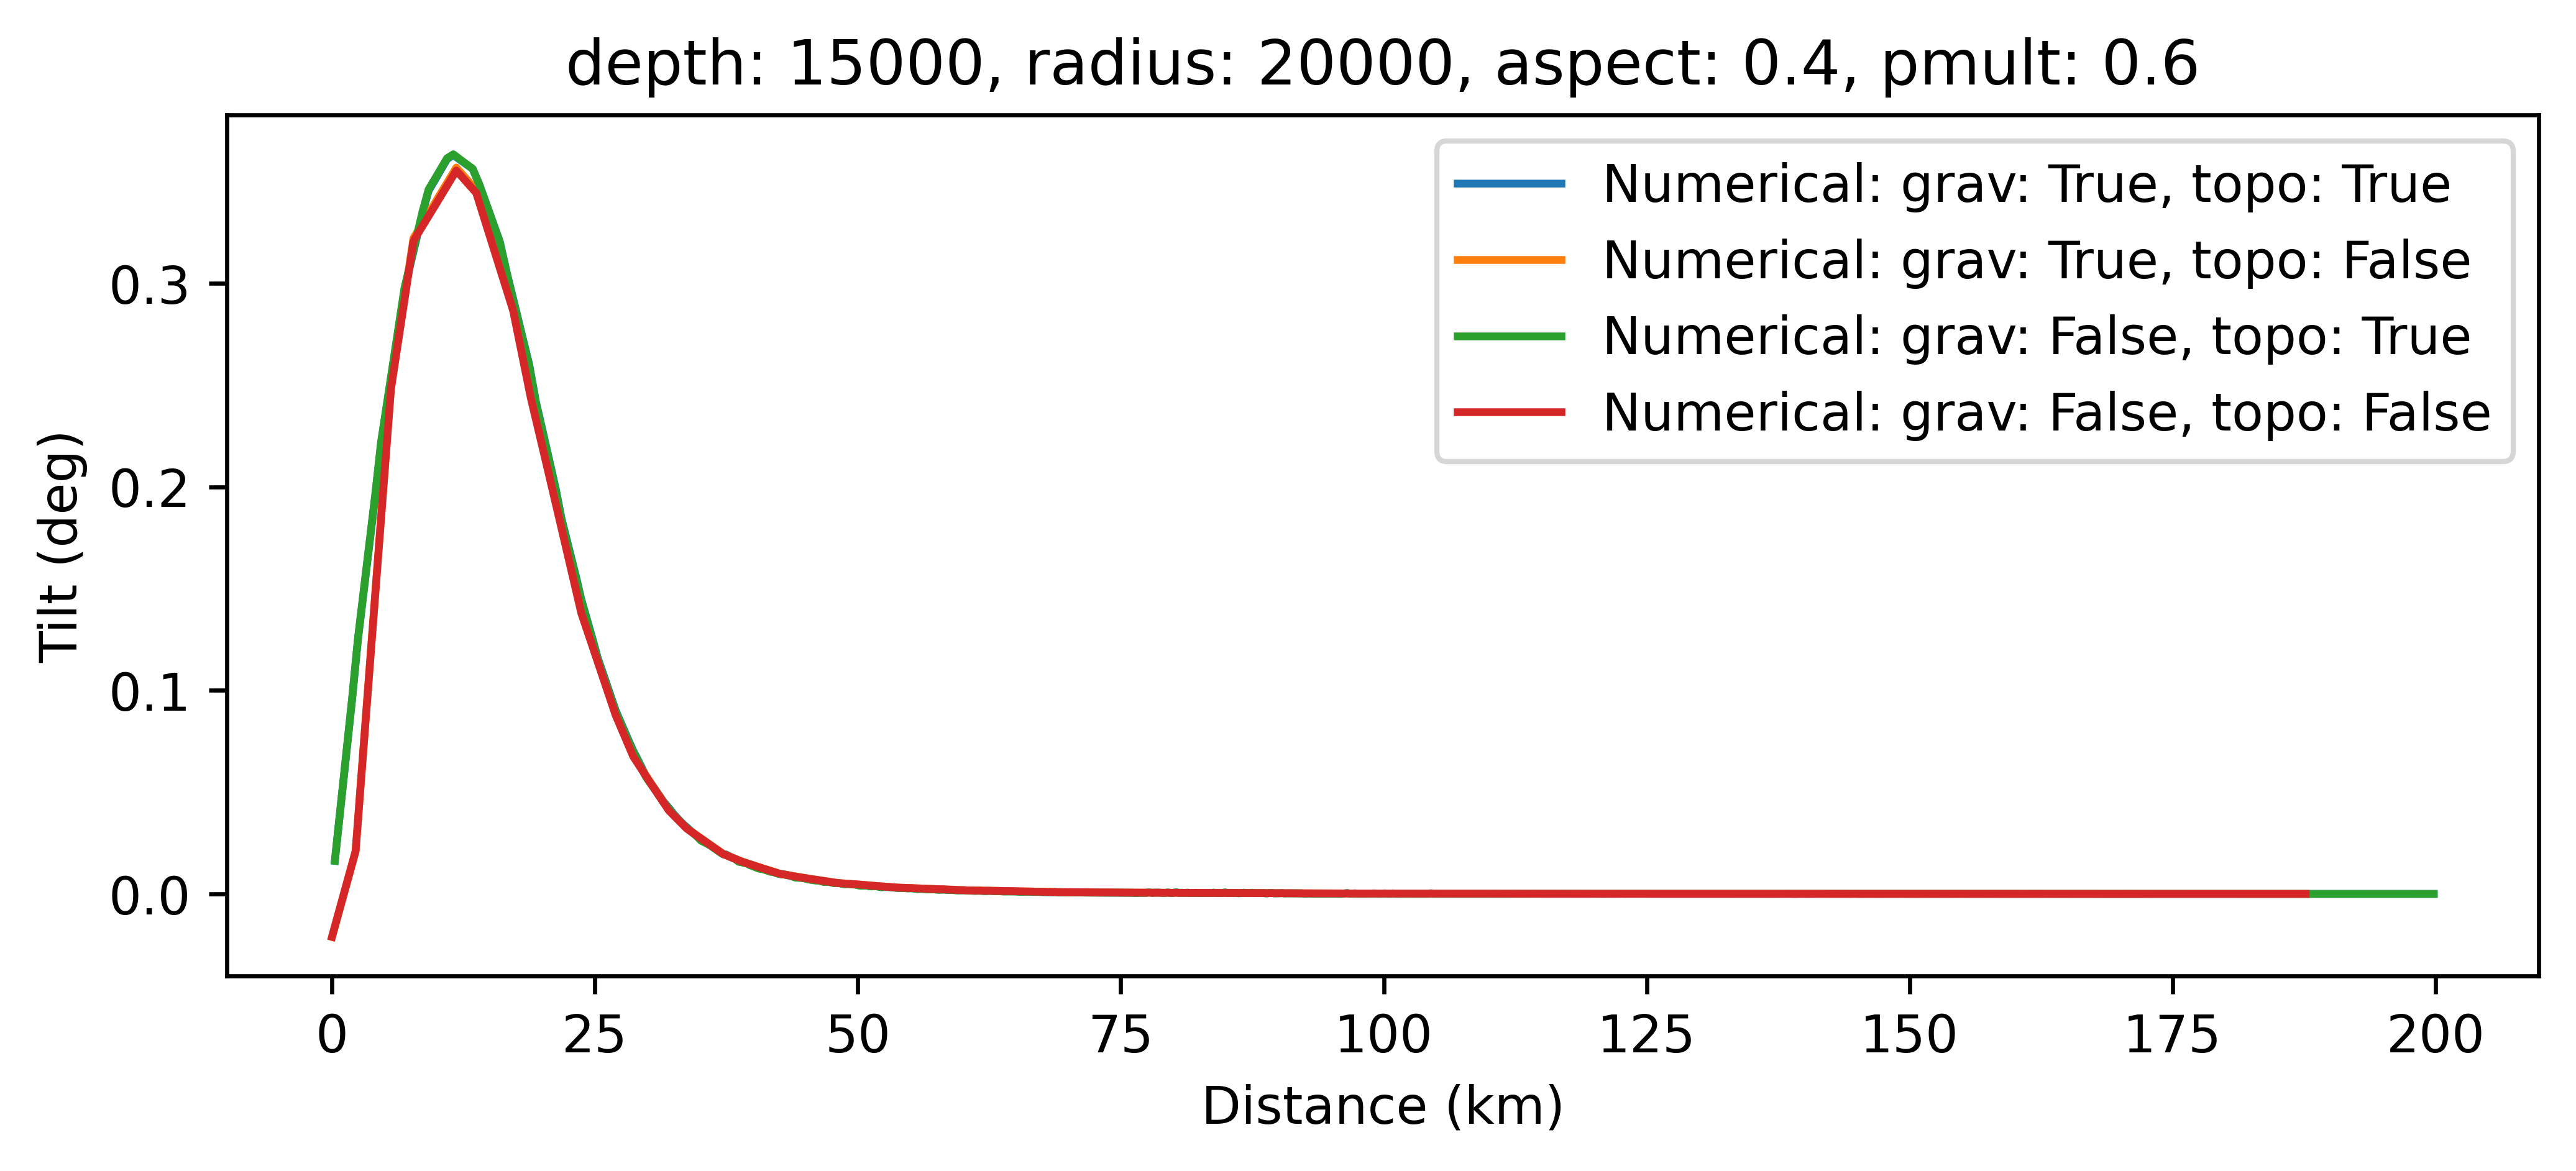

In [124]:
grav_topo_test_sweep.plot_tilt()  # name='grav-topo-test'

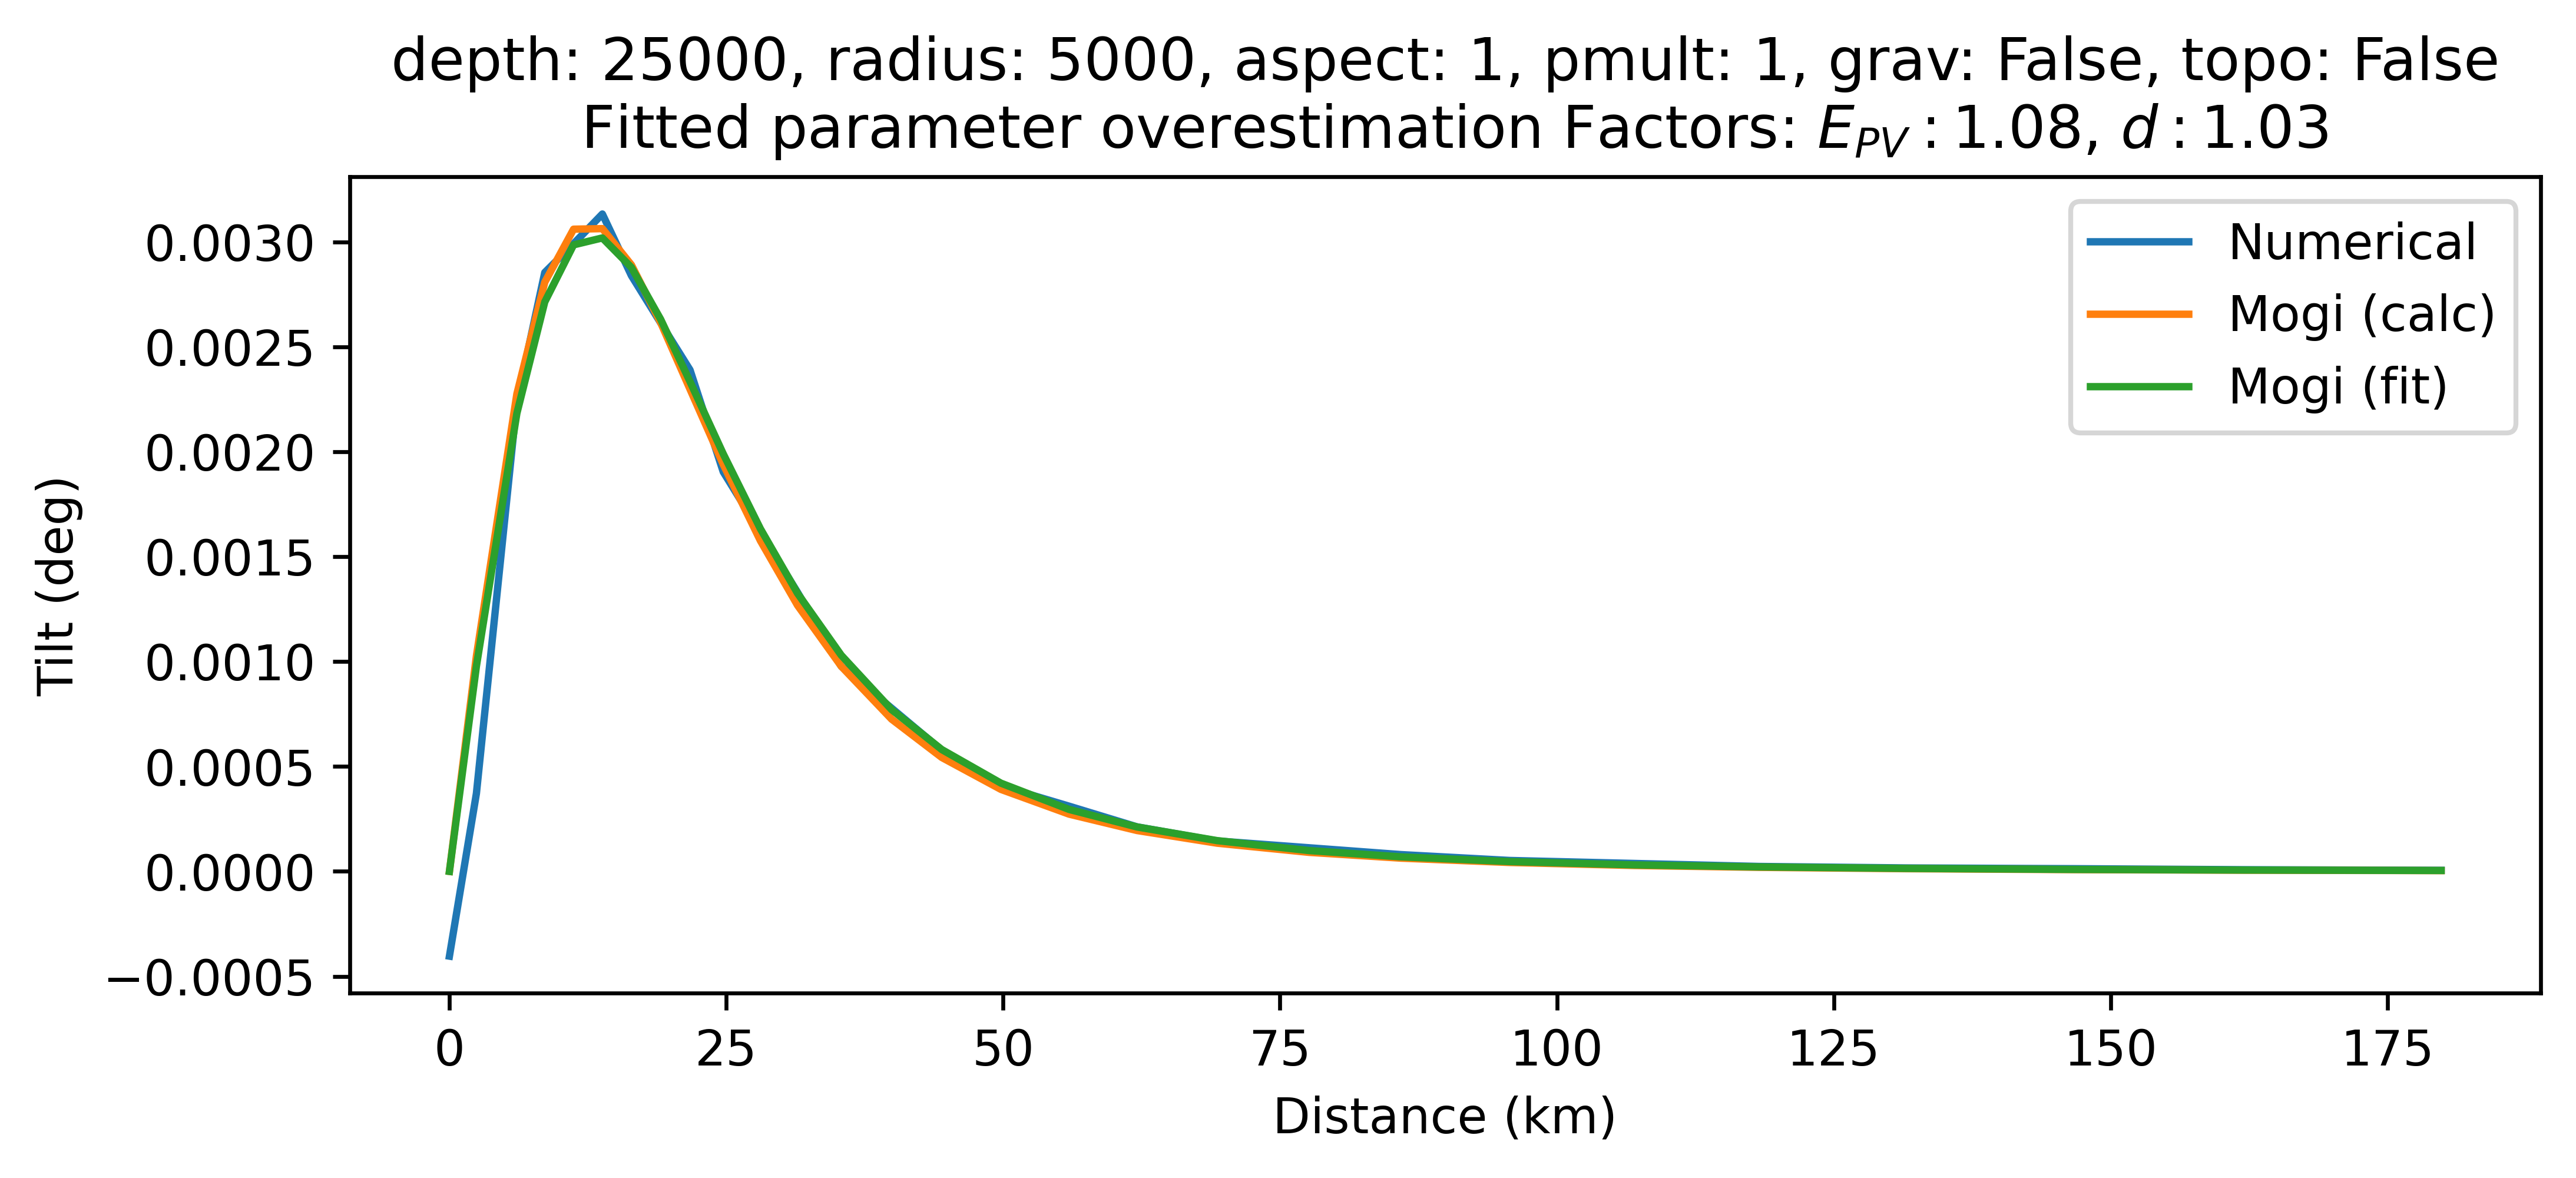

In [50]:
mogi_test_sweep.plot_tilt(calc_mogi=True, fit_mogi=True)  # name='mogi-test'

In [ ]:
# name='mogi-test-shallow-oblate'
mogi_shallow_oblate_test_sweep.plot_tilt(calc_mogi=True, fit_mogi=True)

WORK IN PROGRESS: Reservoir Geometry Plot Function for Sweep

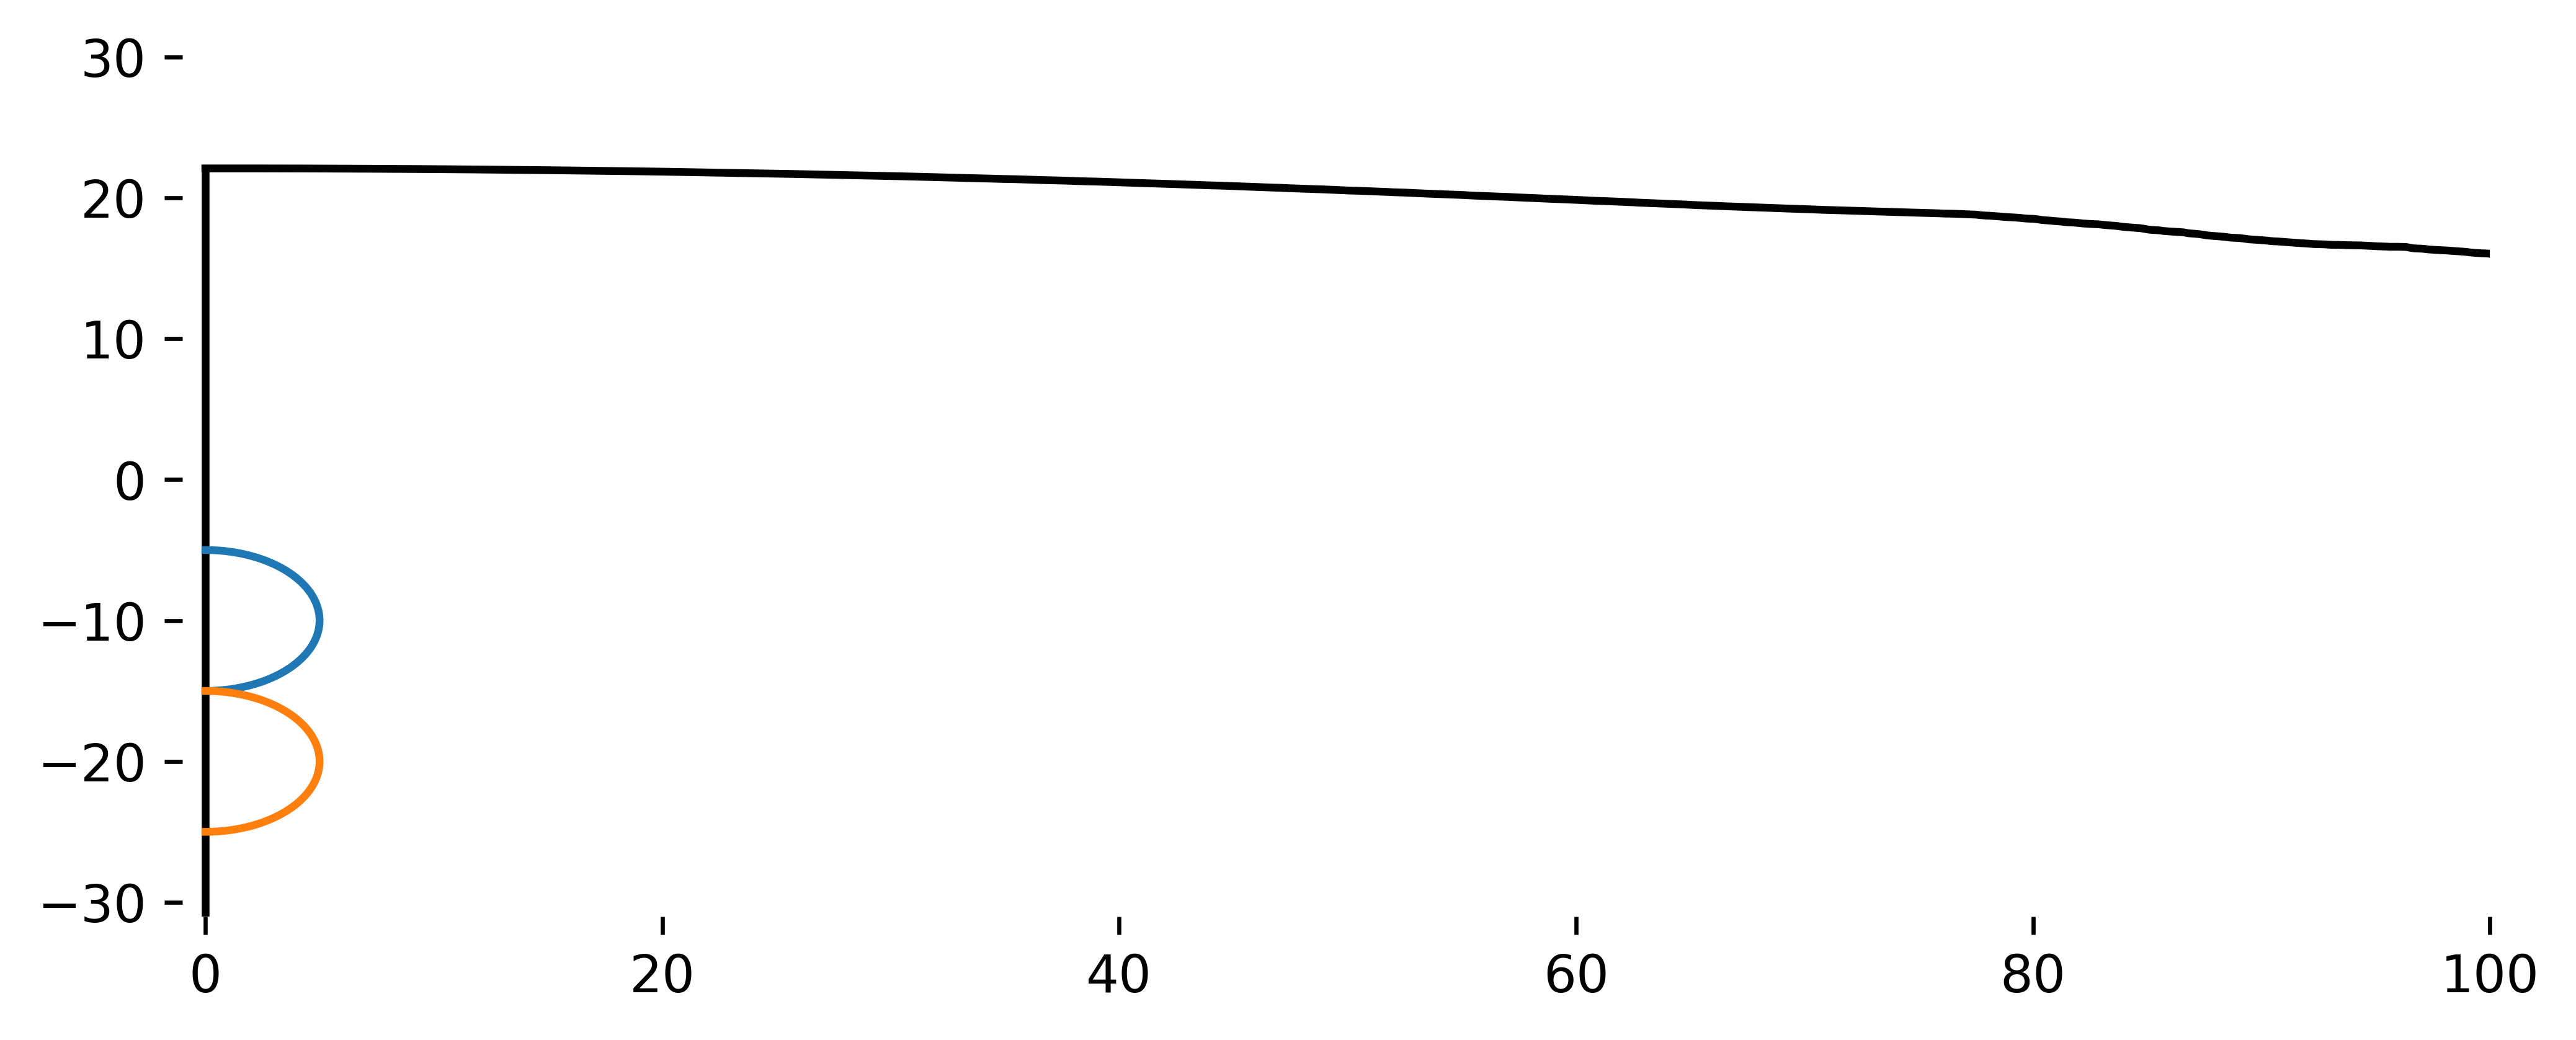

In [137]:
mogi_shallow_oblate_test_sweep = ParamSweep({
    "depth": [15_000],
    "radius": [20_000],
    "aspect": [.4],
    "pmult": [.6],
    "grav": [False],
    "topo": [True],
})

depth = [10_000, 20_000]
radius = full_sweep.params['radius']
aspect = full_sweep.params['aspect']


top_surface_km = np.concatenate((topo, [[2_000_000], [0]]),1) / 1000

fig, ax = plt.subplots(figsize=(8,3),dpi=600)

sns.lineplot(x=top_surface_km[0], y=top_surface_km[1], c='black')

sns.lineplot(x=[0, 2000], y=[-600, -600], c='black')

plt.vlines(x=[0,2_000], ymin=-600, ymax=[top_surface_km[1,0], 0], colors=['black'])

for geometry in itertools.product(depth, radius, aspect):
    depth, radius, aspect = geometry
    v= -depth/1000    #y-position of the center
    a= radius / 1000     #radius on the x-axis
    b= radius*aspect / 1000    #radius on the y-axis
    t = np.linspace(-np.pi/2, np.pi/2, 100)
    plt.plot(a*np.cos(t), v+b*np.sin(t))

plt.xlim(-1, 100)
plt.ylim(-31, 30)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

Define a function for plotting a full center scatter plot against a numerical sweep. (Not used in manuscript).

In [ ]:
def combined_plot(sweep: ParamSweep, centers: list[Center], name: str = None): # type: ignore
    fig = plt.figure(figsize=(8, 5), dpi=600)

    for model in sweep.models:
        label = '{}'.format({param: model.params[param] for param in sweep.variables})
        label = label.replace("{", "")
        label = label.replace("}", "")
        label = label.replace("'", "")
        sns.lineplot(data=model.attributes, y="tilt", x="dist_km", label=label)

    for center in centers:
        sns.scatterplot(data=center.data, x='dist_km', y='tilt', label=center.cID)

    model_title = f'{sweep.constants}'
    model_title = model_title.replace("{", "")
    model_title = model_title.replace("}", "")
    model_title = model_title.replace("'", "")
    plt.title(f"Radial Tilt: {model_title}")

    plt.title(f"Model Parameters: {model_title}")
    plt.xlabel("Distance (km)")
    plt.ylabel("Tilt (deg)")
    plt.legend()

    # save plot with name if passed as argument
    if name is not None:
        save_pdf(name)

combined_plot(mogi_shallow_oblate_test_sweep, [centers_calc[0]])